In [ ]:
# default_exp funcs.tt_rescale

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Training loop simulator learning

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.predict import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, extract_psf_roi, mic_inp_apply_inds, add_pos_noise, concat_micro_inp
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform, get_phased_ints
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb
import kornia

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
losses = []
int_means_col = []

In [ ]:
#export 
def rescale_train(cfg,
          model, 
          microscope,
          post_proc,
          dl, 
          optim_dict):
    
    save_dir = Path(cfg.output.save_dir)
    model.cuda()

    # Load codebook 
    if 'codebook' in cfg:
        code_ref, targets = hydra.utils.instantiate(cfg.codebook)

    # Controls which genmodel parameters are optimized
    for name, p in microscope.named_parameters():
        if name == 'channel_facs':
            p.requires_grad = True
        else:
            False

    for batch_idx in range(0, cfg.training.num_iters+1):

        optim_dict['optim_mic'].zero_grad()

        with torch.no_grad():
            
            ret_dict = next(iter(dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
            if cfg.genm.microscope.col_shifts_enabled:
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
                colshift_crop = get_color_shift_inp(microscope.color_shifts, microscope.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
            else:
                zcrop, ycrop, xcrop, colshift_crop = None, None, None, None
        
            x = x * microscope.get_ch_mult().detach()
        
            out_inp = torch.concat([x,colshift_crop], 1) if colshift_crop is not None else x
            out_inp = model.tensor_to_dict(model(out_inp))
            proc_out_inp = post_proc.get_micro_inp(out_inp)
                        
        if len(proc_out_inp[1]) > 0:
        
            ch_out_inp = microscope.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop, xcrop=xcrop)

            # Get ch_fac loss
            ch_inds = ch_out_inp[0][1]
            int_vals = ch_out_inp[-2]

            int_means = torch.ones(cfg.genm.exp_type.n_channels).cuda()
            for i in range(cfg.genm.exp_type.n_channels):
                if i in ch_inds:
                    int_means[i] = int_vals[ch_inds == i].mean() / int_vals.mean()
            int_means_col.append(int_means.detach())
#             print(int_means)        
            ch_fac_loss = torch.sqrt(torch.mean((microscope.channel_facs - microscope.channel_facs.detach() / int_means)**2))

            ch_fac_loss.backward()
            torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)

            optim_dict['optim_mic'].step()
            optim_dict['sched_mic'].step()
            
            losses.append(ch_fac_loss.item())

            # Logging
            if batch_idx % cfg.output.log_interval == 0:

                print(ch_fac_loss)
#                 print(micro.channel_facs)

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_24/scale:500//train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_2/channel_facs:False///train.yaml')

cfg.output.log_interval = 50
cfg.training.bs = 50

cfg.training.num_iters = 5000
cfg.training.mic.opt.lr = 0.01
codebook, targets = hydra.utils.instantiate(cfg.codebook)

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in u

In [ ]:
# cfg.data_path.image_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled_images151.tif'

In [ ]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(codebook)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
10 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl').cuda()
micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope.pkl'), strict=False)

<All keys matched successfully>

In [ ]:
init = cpu(micro.channel_facs)
gt = [1.0242, 1.0332, 0.8592, 0.9347, 1.1251, 0.9358, 1.0864, 0.8788, 0.7184,
        0.8038, 0.7526, 0.9513, 0.7877, 0.8720, 0.8223, 0.9490, 0.9773, 1.2481,
        1.0047, 0.5698, 1.1487, 1.0143]

nan
0.8998101867392839


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


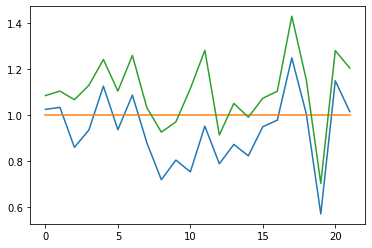

In [ ]:
plt.plot(gt)
plt.plot(init)
plt.plot(cpu(micro.channel_facs))
print(np.corrcoef(gt,init)[0,1])
print(np.corrcoef(gt,cpu(micro.channel_facs))[0,1])

In [ ]:
optim_dict = {}
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])

In [ ]:
code_ref, targets = hydra.utils.instantiate(cfg.codebook)
post_proc.codebook = torch.tensor(code_ref)

In [ ]:
rescale_train(cfg=cfg,
     model=model, 
     microscope=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict)

tensor(0.1065, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0291, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0337, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0243, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0219, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<SqrtBackward0>)


KeyboardInterrupt: 

In [ ]:
len(int_means_col)
tra = torch.stack(int_means_col, 0)

In [ ]:
plt.plot(cpu(tra).mean(0))

In [ ]:
plt.plot(cpu(decode_dl.dataset.volumes).mean(0).mean(-1).mean(-1).mean(-1))

In [ ]:
for i in range(10):
    plt.plot(cpu(int_means_col[i]))
    plt.show()

In [ ]:
!nbdev_build_lib

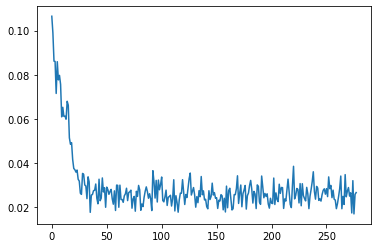

In [ ]:
plt.plot(losses)